In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['NEURITE_BACKEND'] = 'pytorch'
os.environ['VXM_BACKEND'] = 'pytorch'
import voxelmorph as vxm

3 Steps of Registration are:
1. Transformation
2. Optimisation
3. Cost Function

Ill first generate a digital phatom of SAX (short axis slices of heart):
A digital phantom is a simulated image or dataset that mimics the appearance and properties of real-world medical imaging

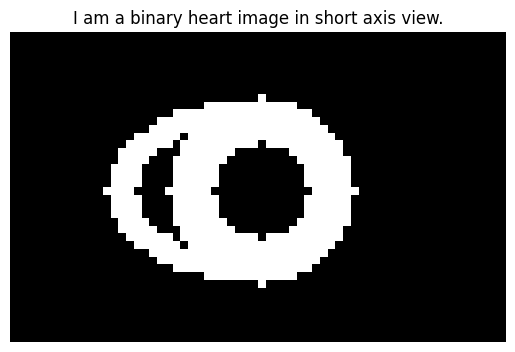

In [2]:
# Define image dimensions and center
image_size = (40, 64)
center = [20, 32]

# LV and RV radii (adjust as needed)
r_lv = [6, 12]  # LV endocardium and epicardium radii
r_rv = [16, 20, 9, 12]  # RV radii for ellipse (endo_a, epi_a, endo_b, epi_b)

# Create coordinate grid
y, x = np.ogrid[-center[0]:image_size[0] - center[0], -center[1]:image_size[1] - center[1]]

# Create LV masks
mask_lv_endo = x**2 + y**2 <= r_lv[0]**2  # Endocardium
mask_lv_epi = x**2 + y**2 <= r_lv[1]**2  # Epicardium

lv_mask = np.zeros(image_size)
lv_mask[mask_lv_epi] = 1  # Epicardium
lv_mask[mask_lv_endo] = 0  # Hollow out the endocardium

# Create RV masks (elliptical shape)
mask_rv_epi = ((x**2) / r_rv[1]**2 + (y**2) / r_rv[3]**2) <= 1  # Epicardium
mask_rv_endo = ((x**2) / r_rv[0]**2 + (y**2) / r_rv[2]**2) <= 1  # Endocardium

rv_mask = np.zeros(image_size)
rv_mask[mask_rv_epi] = 1  # Epicardium
rv_mask[mask_rv_endo] = 0  # Hollow out the endocardium
rv_mask[:, center[1]:] = 0  # Keep RV on the left half

# Combine LV and RV masks
heart_mask = lv_mask + rv_mask
heart_mask[heart_mask > 1] = 1  # Ensure binary mask

# Display the result
plt.imshow(heart_mask, cmap='gray')
plt.title("I am a binary heart image in short axis view.")
plt.axis("off")
plt.show()

# Transformation

To do the subpixel translation, we need to shift the pixels, then do the intepolation.

First ill do a neighbour interpolation.

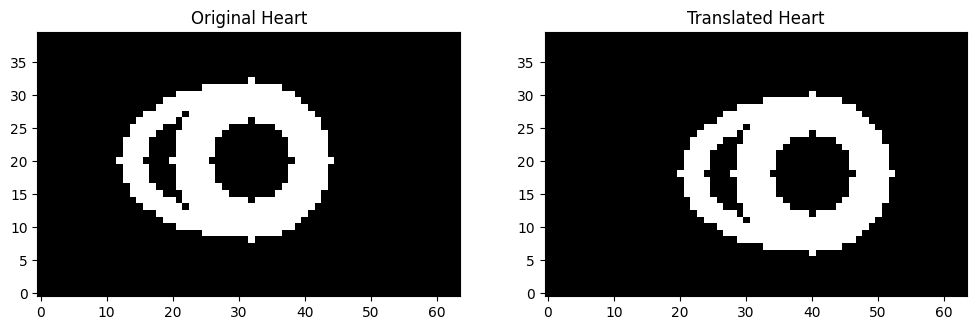

In [3]:
translated_values = np.zeros(heart_mask.shape)

shift_x = 2.4
shift_y = -7.6
padding_value = 0


for new_index_x in range(translated_values.shape[0]):
    for new_index_y in range(translated_values.shape[1]):
        previous_index_x = int(np.round(new_index_x + shift_x))
        previous_index_y = int(np.round(new_index_y + shift_y))
        if previous_index_x >= 0 and previous_index_x < translated_values.shape[0] and \
            previous_index_y >= 0 and previous_index_y < translated_values.shape[1]:
            translated_values[new_index_x, new_index_y] = heart_mask[previous_index_x, previous_index_y]
        else:
            translated_values[new_index_x, new_index_y] = padding_value

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(heart_mask,
           cmap=plt.get_cmap('gray'),
           aspect='equal',
           origin='lower',
           interpolation='nearest')
plt.title('Original Heart')
plt.subplot(1, 2, 2)
plt.imshow(translated_values,
           cmap=plt.get_cmap('gray'),
           aspect='equal',
           origin='lower',
           interpolation='nearest')
plt.title('Translated Heart')
plt.show()

Now this is linear interpolation

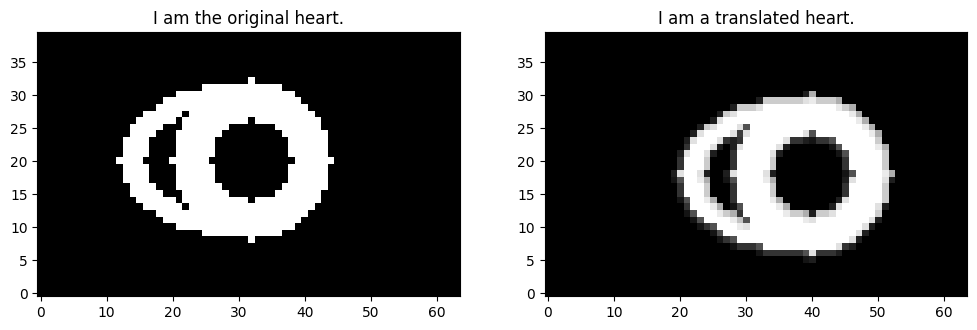

In [4]:
for new_index_x in range(translated_values.shape[0]):
    for new_index_y in range(translated_values.shape[1]):
        previous_index_x = int(np.floor(new_index_x + shift_x))
        previous_index_y = int(np.floor(new_index_y + shift_y))
        relative_x = new_index_x + shift_x - previous_index_x
        relative_y = new_index_y + shift_y - previous_index_y
        for [a,b] in [[0,0],[0,1],[1,0],[1,1]]:
            if previous_index_x + a >=0 and previous_index_x + a < heart_mask.shape[0] and \
                previous_index_y + b >= 0 and previous_index_y +b < heart_mask.shape[1]:
                    translated_values[new_index_x,new_index_y] += \
                    heart_mask[previous_index_x + a, previous_index_y + b]*\
                        abs(1-a-relative_x)*abs(1-b-relative_y)
                # translated_value, initialised to be zero
                # (1- relative) * value from the floating image
                # a = 0 add the weighted value from left (same as b,since initial is 0)
                # a = 1 add the weighted value from right
            else:
                translated_values[new_index_x, new_index_y] = padding_value *\
                    abs(1-a-relative_x)*abs(1-b-relative_y)

# show the image
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(heart_mask,
           cmap=plt.get_cmap('gray'),
           aspect='equal',
           origin='lower',
           interpolation='nearest')
plt.title('I am the original heart.')
plt.subplot(1, 2, 2)
plt.imshow(translated_values,
           cmap=plt.get_cmap('gray'),
           aspect='equal',
           origin='lower',
           interpolation='nearest')
plt.title('I am a translated heart.')
plt.show()

# Affine Transformation

I will revise the affine matrix to apply a **30-degree rotation** to the center of the original heart image and use **linear interpolation** to ensure smooth results.

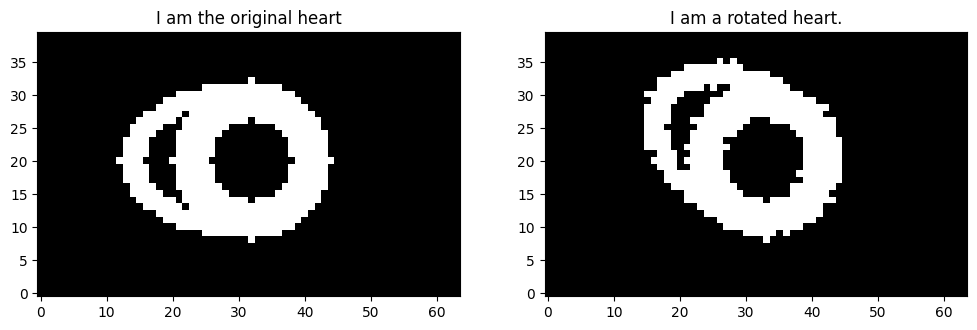

In [5]:
imgsize = np.shape(heart_mask)

translated_values = np.zeros(imgsize)

translation_x = imgsize[0]/2
translation_y = imgsize[1]/2
theta = np.pi/6
padding_value = 0

rot_matrix = np.eye(3)
rot_matrix[0,0] = np.cos(theta)
rot_matrix[0,1] = np.sin(theta)
rot_matrix[1,0] = -np.sin(theta)
rot_matrix[1,1] = np.cos(theta)

cen_matrix = np.eye(3)
cen_matrix[0,2] = translation_x
cen_matrix[1,2] = translation_y

icen_matrix = np.eye(3)
icen_matrix[0,2] = -translation_x
icen_matrix[1,2] = -translation_y

trans_matrix = np.dot(np.dot(cen_matrix,rot_matrix),icen_matrix)

for new_index_x in range(imgsize[0]):
    for new_index_y in range(imgsize[1]):
        # here we will apply the transformation matrix to every x and y in the matrix
        corres_x, corres_y,_ = np.dot(trans_matrix,[new_index_x, new_index_y, 1])
        # then we will interpolate every new coordinate according to the surroundings
        previous_index_x = int(np.floor(corres_x))
        previous_index_y = int(np.floor(corres_y))

        relative_x = corres_x - previous_index_x
        relative_y = corres_y - previous_index_y

        for [a,b] in [0,0],[0,1],[1,0],[1,1]:
            if previous_index_x + a >= 0 and previous_index_x + a < imgsize[0] and \
                previous_index_y + b >= 0 and previous_index_y + b < imgsize[1]:
                translated_values[new_index_x][new_index_y] += \
                    heart_mask[previous_index_x][previous_index_y]*np.abs(1-a-relative_x)*np.abs(1-b-relative_y)
            else:
                translated_values[new_index_x][new_index_y] = \
                    padding_value*np.abs(1-a-relative_x)*np.abs(1-b-relative_y)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(heart_mask, cmap=plt.get_cmap('gray'), aspect='equal',
           origin='lower', interpolation='nearest')
plt.title('I am the original heart')
plt.subplot(1, 2, 2)
plt.imshow(translated_values, cmap=plt.get_cmap('gray'), aspect='equal',
           origin='lower', interpolation='nearest')
plt.title('I am a rotated heart.')
plt.show()

# Optimisation and Loss function

In [6]:
def affine_register(moving_img,
                    fixed_img,
                    lr=1E-5,
                    epochs=1000,
                    device='cpu',
                    criterions=None, # one of nn.MSELoss(), NCCLoss, NMILoss()
                    ):
  # params initialization
  params = torch.tensor([1.0, 0.0, 0.0,  # a, b, tx
                        0.0, 1.0, 0.0],  # c, d, ty
                        requires_grad=True)

  # Optimizer
  optimizer = torch.optim.Adam([params], lr=lr)

  losses = []
  # Optimization loop
  for iteration in range(epochs):
      # Create affine matrix
      affine_matrix = params.view(2, 3).unsqueeze(0)  # Shape: (1, 2, 3)

      # Warp the moving image
      moved_grid = F.affine_grid(affine_matrix, moving_img.size(), align_corners=True)
      moved_img = F.grid_sample(moving_img, moved_grid, align_corners=True)

      # Compute similarity loss (e.g., Mean Squared Error)
      loss = criterions(moved_img, fixed_img)

      # Backpropagation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      losses.append(loss.item())

  # plot the error.
  plt.plot(losses, label='Error')
  plt.title('Optimization Criterion')
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.show()
  # Final transformation matrix
  moved_affine = params.view(2, 3).detach()

  # Warp the moving image with the final transformation
  moved_grid = F.affine_grid(moved_affine.unsqueeze(0), moving_img.size(), align_corners=True)
  moved_img = F.grid_sample(moving_img, moved_grid, align_corners=True)
  return moved_img, moved_affine

In [7]:
device = 'cpu'
fixed_img = torch.Tensor(heart_mask).unsqueeze(0).unsqueeze(0).to(device)
moving_img = torch.Tensor(translated_values).unsqueeze(0).unsqueeze(0).to(device)

I will define the **Mean Squared Error (MSE)** as the loss function and use the `affine_register` function to optimize the transformation parameters that align the moving image to the fixed image.

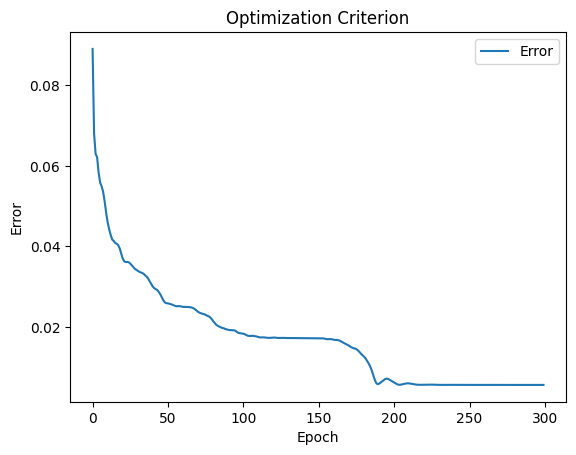

Text(0.5, 1.0, 'fixed')

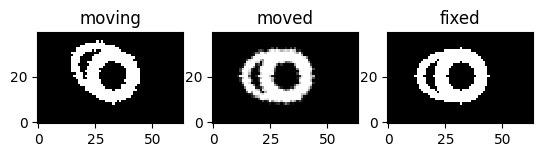

In [8]:
def MSELoss(moved, target):
    """
    Compute Mean Squared Error (MSE) between two images.
    Args:
        predicted (torch.Tensor): The moving image after applying the transformation.
        target (torch.Tensor): The fixed reference image.
    Returns:
        torch.Tensor: The computed MSE loss value.
    """
    return torch.mean((moved - target) ** 2)

# Usage example within the affine_register function
mse_criterion = MSELoss  # Pass MSELoss as the criterions parameter


moved_img, moved_affine = affine_register(moving_img = moving_img,
                                          fixed_img = fixed_img,
                                          lr = 0.01,
                                          epochs = 300,
                                          device = 'cpu',
                                          criterions = mse_criterion)

plt.subplot(1, 3, 1)
plt.imshow(moving_img.squeeze().detach().cpu().numpy(), cmap=plt.get_cmap('gray'), aspect='equal',
           origin='lower', interpolation='nearest')
plt.title('moving')

plt.subplot(1, 3, 2)
plt.imshow(moved_img.squeeze().detach().cpu().numpy(), cmap=plt.get_cmap('gray'), aspect='equal',
           origin='lower', interpolation='nearest')
plt.title('moved')

plt.subplot(1, 3, 3)
plt.imshow(fixed_img.squeeze().detach().cpu().numpy(), cmap=plt.get_cmap('gray'), aspect='equal',
           origin='lower', interpolation='nearest')
plt.title('fixed')

Now I revise the `affine_register` function to create a `rigid_register` function. For **rigid transformations**, the transformation is limited to **rotation** and **translation**. This means scaling and shearing are not allowed, reducing the number of free parameters to **three**: $ \theta, t_x, t_y $.

In [9]:
def rigid_register(moving_img,
                    fixed_img,
                    lr=1E-5,
                    epochs=1000,
                    device='cpu',
                    criterions=None, # one of nn.MSELoss(), NCCLoss, NMILoss()
                    ):
  # params initialization, just two translation and one rotation
  theta = torch.nn.Parameter(torch.tensor(0.0))  # Rotation angle (radians)
  tx = torch.nn.Parameter(torch.tensor(0.0))    # Translation in x
  ty = torch.nn.Parameter(torch.tensor(0.0))    # Translation in y

  # Optimizer
  optimizer = torch.optim.Adam([theta, tx, ty], lr=lr)

  losses = []
  # Optimization loop
  for iteration in range(epochs):
      # Create affine matrix
      cos_theta = torch.cos(theta)
      sin_theta = torch.sin(theta)

      affine_matrix = torch.zeros(1, 2, 3)
      affine_matrix[0, 0, 0] = cos_theta
      affine_matrix[0, 0, 1] = -sin_theta
      affine_matrix[0, 0, 2] = tx
      affine_matrix[0, 1, 0] = sin_theta
      affine_matrix[0, 1, 1] = cos_theta
      affine_matrix[0, 1, 2] = ty

      # Warp the moving image
      moved_grid = F.affine_grid(affine_matrix, moving_img.size(), align_corners=True)
      moved_img = F.grid_sample(moving_img, moved_grid, align_corners=True)

      # Compute similarity loss (e.g., Mean Squared Error)
      loss = criterions(moved_img, fixed_img)

      # Backpropagation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      losses.append(loss.item())
      # plot the error.

  plt.plot(losses, label='Error')
  plt.title('Optimization Criterion')
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.show()
  # Final transformation matrix
  # Warp the moving image with the final transformation
  moved_grid = F.affine_grid(moved_affine.unsqueeze(0), moving_img.size(), align_corners=True)
  moved_img = F.grid_sample(moving_img, moved_grid, align_corners=True)
  return moved_img, moved_affine

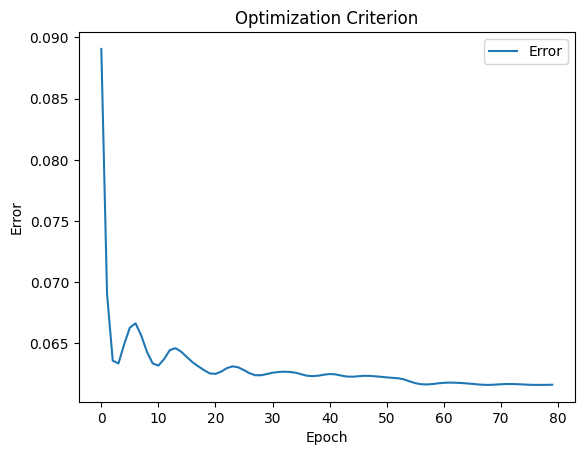

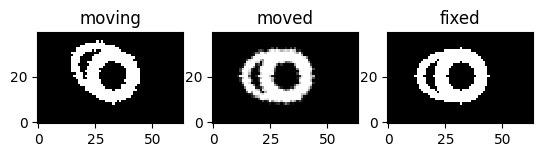

In [10]:
moved_img, moved_affine = rigid_register(moving_img,
                                          fixed_img,
                                          lr = 0.01,
                                          epochs = 80,
                                          device = 'cpu',
                                          criterions = nn.MSELoss())
plt.subplot(1, 3, 1)
plt.imshow(moving_img.squeeze().detach().cpu().numpy(), cmap=plt.get_cmap('gray'), aspect='equal',
           origin='lower', interpolation='nearest')
plt.title('moving')

plt.subplot(1, 3, 2)
plt.imshow(moved_img.squeeze().detach().cpu().numpy(), cmap=plt.get_cmap('gray'), aspect='equal',
           origin='lower', interpolation='nearest')
plt.title('moved')

plt.subplot(1, 3, 3)
plt.imshow(fixed_img.squeeze().detach().cpu().numpy(), cmap=plt.get_cmap('gray'), aspect='equal',
           origin='lower', interpolation='nearest')
plt.title('fixed')

plt.show()

Next, I try to define the **Normalized Cross-Correlation (NCC)** as the loss function and use the `rigid_register` function to optimize the transformation parameters. If the `rigid_register` function fails, I can alternatively refer back to the `affine_register` function.

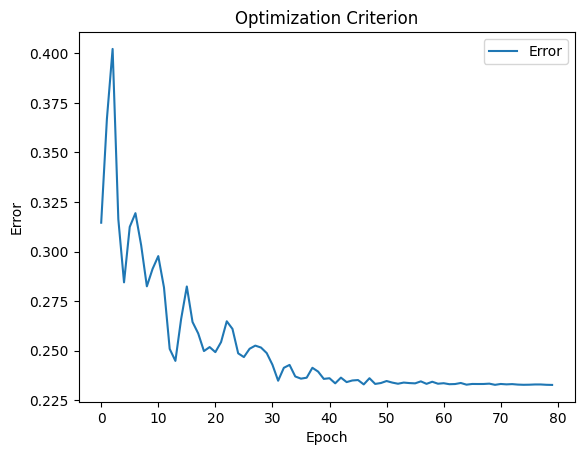

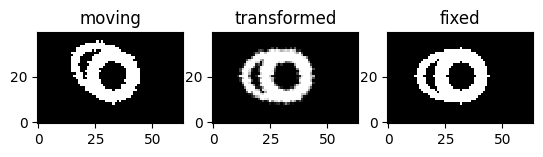

In [11]:
def NCCLoss(moved, fixed, eps=1e-8):
    """
    Compute Normalized Cross-Correlation (NCC) loss between two images.
    Args:
        moved (torch.Tensor): The moving image after applying the transformation.
        fix (torch.Tensor): The fixed reference image.
        eps (float): Small constant to avoid division by zero.
    Returns:
        torch.Tensor: The computed NCC loss value.
    """
    moved_mean = moved.mean(dim=(-1, -2), keepdim=True)
    fixed_mean = fixed.mean(dim=(-1, -2), keepdim=True)

    moved_var = ((moved - moved_mean) ** 2).mean(dim=(-1, -2), keepdim=True)
    fixed_var = ((fixed - fixed_mean) ** 2).mean(dim=(-1, -2), keepdim=True)

    covariance = ((moved - moved_mean) * (fixed - fixed_mean)).mean(dim=(-1, -2), keepdim=True)

    ncc = covariance / (torch.sqrt(moved_var * fixed_var + eps) + eps)
    loss = 1 - ncc.mean()
    return loss

moved_img, moved_affines = rigid_register(moving_img,
                                          fixed_img,
                                          lr = 0.1,
                                          epochs = 80,
                                          device = 'cpu',
                                          criterions = NCCLoss)
plt.subplot(1, 3, 1)
plt.imshow(moving_img.squeeze().detach().cpu().numpy(), cmap=plt.get_cmap('gray'), aspect='equal',
           origin='lower', interpolation='nearest')
plt.title('moving')

plt.subplot(1, 3, 2)
plt.imshow(moved_img.squeeze().detach().cpu().numpy(), cmap=plt.get_cmap('gray'), aspect='equal',
           origin='lower', interpolation='nearest')
plt.title('transformed')

plt.subplot(1, 3, 3)
plt.imshow(fixed_img.squeeze().detach().cpu().numpy(), cmap=plt.get_cmap('gray'), aspect='equal',
           origin='lower', interpolation='nearest')
plt.title('fixed')

plt.show()

I will now use the **Mutual Information (MI)** as the loss function and the `affine_register` function to optimize the transformation parameters on real cardiac magentic resonance images (cine and T2).

I now transition from **binary CMR images** to **real-world Cine and T2 CMR images**, adopted from the public **MSCMR dataset**. Despite the use of motion control techniques such as **breath-holding** and **cardiac triggering**, shifts remain a common occurrence, necessitating robust image registration techniques.

Unlike the simplified digital phantoms I just created, these real-world images feature **complex backgrounds**, introducing significant challenges to the registration process. These complexities highlight the need for advanced and adaptable registration frameworks capable of handling variability and noise in real-collected datasets.

### Implementation Steps

1. Compute the joint histogram of the moving and fixed images.
2. Normalize the histogram to get the joint probability distribution, $p(x, y)$.
3. Calculate the marginal distributions, $p(x)$ and $p(y)$.
4. Compute the MI 

In [13]:
# upload npz
MSCMR = np.load('realSCMR.npz')
print(MSCMR.keys())

KeysView(NpzFile 'realSCMR.npz' with keys: C0, T2, T2_transformed)


Text(0.5, 1.0, 'T2 Transformed')

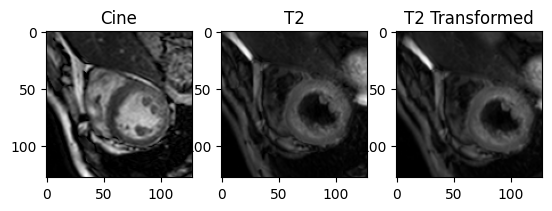

In [14]:
# plot the three images
plt.subplot(1, 3, 1)
plt.imshow(MSCMR['C0'],cmap = 'gray')
plt.title('Cine')

plt.subplot(1, 3, 2)
plt.imshow(MSCMR['T2'],cmap = 'gray')
plt.title('T2')

plt.subplot(1, 3, 3)
plt.imshow(MSCMR['T2_transformed'],cmap = 'gray')
plt.title('T2 Transformed')

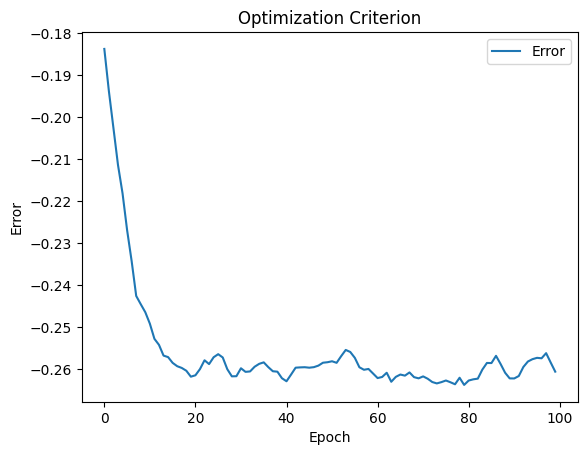

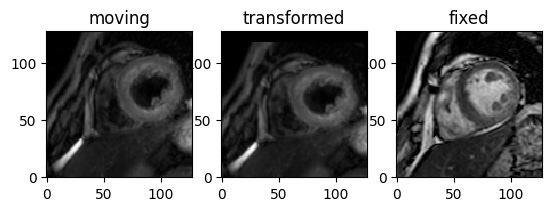

In [15]:
# mutual information
def mutual_information_loss(y_true, y_pred, sigma_ratio=0.32, minval=0., maxval=1., num_bin=32):
    """
    Compute the mutual information (MI) loss between two images.

    Args:
        y_true (torch.Tensor): Ground truth image tensor of shape (N, C, H, W).
        y_pred (torch.Tensor): Predicted image tensor of shape (N, C, H, W).
        sigma_ratio (float): Ratio to calculate Gaussian kernel sigma.
        minval (float): Minimum intensity value for bins.
        maxval (float): Maximum intensity value for bins.
        num_bin (int): Number of bins for the histogram.

    Returns:
        torch.Tensor: Scalar value representing the negative mutual information loss.
    """
    # Clamp values to the specified range
    y_pred = torch.clamp(y_pred, minval, maxval)
    y_true = torch.clamp(y_true, minval, maxval)

    # Reshape tensors to (N, -1, 1)
    y_true = y_true.view(y_true.shape[0], -1, 1)
    y_pred = y_pred.view(y_pred.shape[0], -1, 1)

    nb_voxels = y_pred.shape[1]  # Total number of voxels

    # Create bin centers
    bin_centers = torch.linspace(minval, maxval, num_bin, device=y_true.device)
    vol_bin_centers = bin_centers.unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, num_bin)

    # Sigma for Gaussian approximation
    sigma = torch.mean(bin_centers[1:] - bin_centers[:-1]) * sigma_ratio
    preterm = 1 / (2 * sigma ** 2)

    # Compute Gaussian weights for y_true
    I_a = torch.exp(-preterm * (y_true - vol_bin_centers) ** 2)
    I_a = I_a / torch.sum(I_a, dim=-1, keepdim=True)

    # Compute Gaussian weights for y_pred
    I_b = torch.exp(-preterm * (y_pred - vol_bin_centers) ** 2)
    I_b = I_b / torch.sum(I_b, dim=-1, keepdim=True)

    # Compute joint probabilities
    pab = torch.bmm(I_a.permute(0, 2, 1), I_b) / nb_voxels  # Joint histogram
    pa = torch.mean(I_a, dim=1, keepdim=True)  # Marginal probabilities for y_true
    pb = torch.mean(I_b, dim=1, keepdim=True)  # Marginal probabilities for y_pred

    papb = torch.bmm(pa.permute(0, 2, 1), pb) + 1e-6  # Add small constant for numerical stability
    mi = torch.sum(pab * torch.log(pab / papb + 1e-6), dim=(1, 2))  # Mutual information

    return -mi.mean()  # Negative MI as loss


# fixed_img = torch.Tensor(MSCMR['C0']).unsqueeze(0).unsqueeze(0)
moving_img = torch.Tensor(MSCMR['T2_transformed']).unsqueeze(0).unsqueeze(0)
fixed_img = torch.Tensor(MSCMR['C0']).unsqueeze(0).unsqueeze(0)

# MI = MutualInformation()
moved_img, moved_affines = affine_register(moving_img,
                                          fixed_img,
                                          lr = 0.01,
                                          epochs = 100,
                                          device = 'cpu',
                                          criterions = mutual_information_loss)

plt.subplot(1, 3, 1)
plt.imshow(moving_img.squeeze().detach().numpy(), cmap=plt.get_cmap('gray'), aspect='equal',
           origin='lower', interpolation='nearest')
plt.title('moving')

plt.subplot(1, 3, 2)
plt.imshow(moved_img.squeeze().detach().numpy(), cmap=plt.get_cmap('gray'), aspect='equal',
           origin='lower', interpolation='nearest')
plt.title('transformed')

plt.subplot(1, 3, 3)
plt.imshow(fixed_img.squeeze().detach().numpy(), cmap=plt.get_cmap('gray'), aspect='equal',
           origin='lower', interpolation='nearest')
plt.title('fixed')

plt.show()

# Experimenting with VoxelMorph (and some notes for future ref)
# Deep-Learning Baseline: VoxelMorph with PyTorch

VoxelMorph is a deep-learning-based framework for image registration. It uses a U-Net-like architecture to predict dense deformation fields for aligning images, making it faster and more scalable compared to traditional methods. Below, I test its application using PyTorch and the MNIST dataset as a simplified example.

---

## Key Features of VoxelMorph

1. **End-to-End Learning**:
   - Learns a dense deformation field directly from the data in a single forward pass.
2. **CNN-Based**:
   - Employs a U-Net to predict the deformation field.
3. **Loss Function**:
   - Combines similarity loss (e.g., Mean Squared Error) with a regularization term to enforce smooth deformations.
4. **Applications**:
   - Medical imaging (e.g., MRI, CT scans), computer vision tasks requiring alignment.

---

## VoxelMorph Workflow

1. **Input**: A pair of images (e.g., a moving image and a fixed image).
2. **Network**: A U-Net predicts a dense deformation field.
3. **Transformation**: The deformation field is applied to the moving image to align it with the fixed image.
4. **Loss Function**:
   - Similarity Loss: Ensures alignment of the two images.
   - Regularization Loss: Encourages smoothness in the deformation field.
5. **Output**: The warped image and the deformation field.




In [16]:
import torchvision.datasets as dsets
import torchvision.transforms as transforms

In [17]:
#Downloading MNIST data

train_data = dsets.MNIST(root = './data', train = True,
                        transform = transforms.ToTensor(), download = True)

# take the digit with 5 out of the training dataset
digit_5 = train_data.data[train_data.targets == 5]
print(digit_5.shape)
# normalize the digit_5 to [0,1]
digit_5 = digit_5.float()/255
# just use the first 1000 samples for experiments
digit_5 = digit_5[:1000]

100%|██████████| 9.91M/9.91M [00:00<00:00, 10.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 221kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.42MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 1.86MB/s]

torch.Size([5421, 28, 28])


In [18]:
nb_val = 200  # keep smaller number of samples for a faster training.
nb_tst = 100

x_trn = digit_5[:-(nb_val + nb_tst), ...]
x_val = digit_5[-(nb_val + nb_tst): -nb_tst, ...]
x_tst = digit_5[-nb_tst:, ...]

In [19]:
pad_amount = ((0, 0), (2,2), (2,2))

# fix data
x_trn = np.pad(x_trn, pad_amount, 'constant')
x_val = np.pad(x_val, pad_amount, 'constant')
x_tst = np.pad(x_tst, pad_amount, 'constant')

# verify
print('shape of training data', x_trn.shape)

shape of training data (700, 32, 32)


In [20]:
# configure unet input shape
ndim = 2
inshape = x_trn.shape[1:]

# configure unet features
# unet architecture
enc_nf = [32, 32, 32]
dec_nf = [32, 32, 32, 32, 16]

model = vxm.networks.VxmDense(
    inshape=inshape,
    nb_unet_features=[enc_nf, dec_nf],
    bidir=False,
    int_steps=0,
    int_downsize=2,
)

/opt/anaconda3/envs/voxelmorph-env/lib/python3.10/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:4316.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
def vxm_data_generator(x_data, batch_size=1):
    """
    Generator that takes in data of size [N, H, W], and yields data for
    our custom vxm model. Note that we need to provide numpy data for each
    input, and each output.

    inputs:  moving [bs, H, W, 1], fixed image [bs, H, W, 1]
    outputs: moved image [bs, H, W, 1], zero-gradient [bs, H, W, 2]
    """

    # preliminary sizing
    vol_shape = x_data.shape[1:] # extract data shape
    ndims = len(vol_shape)

    # prepare a zero array the size of the deformation
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])

    while True:
        # prepare inputs:
        # images need to be of the size [batch_size, H, W, 1]
        idx1 = np.random.randint(0, x_data.shape[0], size=batch_size)
        moving_images = x_data[idx1, ..., np.newaxis]
        idx2 = np.random.randint(0, x_data.shape[0], size=batch_size)
        fixed_images = x_data[idx2, ..., np.newaxis]
        inputs = [moving_images, fixed_images]

        # prepare outputs (the 'true' moved image):
        # of course, we don't have this, but we know we want to compare
        # the resulting moved image with the fixed image.
        # we also wish to penalize the deformation field.
        outputs = [fixed_images, zero_phi]

        yield (inputs, outputs)

In [22]:
# let's train
train_generator = vxm_data_generator(x_trn)
in_sample, out_sample = next(train_generator)

In [23]:
# define loss, config
losses = [nn.MSELoss()]
weights = [1]
epochs = 200
learning_rate = 1E-3

In [24]:
# prepare the model for training and send to device
model.to(device)
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
total_loss = []
for epoch in range(epochs):

    epoch_loss = []
    epoch_total_loss = []
    epoch_step_time = []

    for step in range(5):

        # generate inputs (and true outputs) and convert them to tensors
        inputs, y_true = next(train_generator)
        inputs = [torch.from_numpy(d).to(device).float().permute(0, 3, 1, 2) for d in inputs]
        y_true = [torch.from_numpy(d).to(device).float().permute(0, 3, 1, 2) for d in y_true]

        # run inputs through the model to produce a warped image and flow field
        y_pred = model(*inputs)

        # calculate total loss
        loss = 0
        loss_list = []

        for n, loss_function in enumerate(losses):
            curr_loss = loss_function(y_true[n], y_pred[n]) * weights[n]
            loss_list.append(curr_loss.item())
            loss += curr_loss

        epoch_loss.append(loss_list)
        epoch_total_loss.append(loss.item())

        # backpropagate and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    total_loss.append(np.mean(epoch_total_loss))

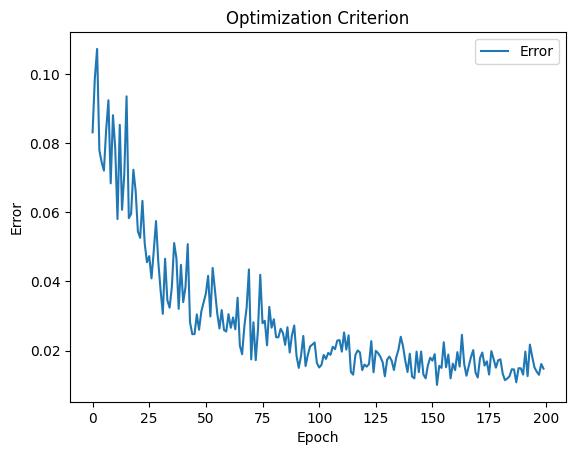

In [25]:
# plot error
plt.plot(total_loss, label='Error')
plt.title('Optimization Criterion')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.show()

Text(0.5, 1.0, 'fixed')

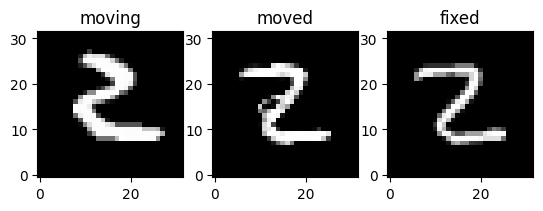

In [26]:
# Evaluation
model.eval()


val_generator = vxm_data_generator(x_val)
in_sample, out_sample = next(val_generator)

# Convert inputs and true outputs to tensors
inputs = [torch.from_numpy(d).to(device).float().permute(0, 3, 1, 2) for d in in_sample]
y_true = [torch.from_numpy(d).to(device).float().permute(0, 3, 1, 2) for d in out_sample]

# Forward pass through the model to generate predictions
with torch.no_grad():  # Disable gradients for evaluation
    y_pred = model(*inputs)

# plot the images
plt.subplot(1, 3, 1)
plt.imshow(in_sample[0][0], cmap=plt.get_cmap('gray'), aspect='equal',
           origin='lower', interpolation='nearest')
plt.title('moving')

plt.subplot(1, 3, 2)
plt.imshow(y_pred[0].squeeze().cpu().detach().numpy(), cmap=plt.get_cmap('gray'), aspect='equal',
           origin='lower', interpolation='nearest')
plt.title('moved')

plt.subplot(1, 3, 3)
plt.imshow(y_true[0].squeeze().cpu().detach().numpy(), cmap=plt.get_cmap('gray'), aspect='equal',
           origin='lower', interpolation='nearest')
plt.title('fixed')

Now to put all I learnt to test, Iwill tackle the challenge of medical imaging registration using the **MedMNIST** dataset. MedMNIST is a large-scale, lightweight benchmark designed for biomedical image classification and segmentation tasks. Specifically, I will train and validate a **VoxelMorph** model to align medical images, leveraging the diverse subsets and labels provided by MedMNIST.

In [27]:
from medmnist import BreastMNIST, RetinaMNIST, PneumoniaMNIST
from torchvision.transforms.functional import pil_to_tensor
import matplotlib.pyplot as plt

IMAGE_SIZE = 64  # ChestMNIST offers sizes: 28, 64, 128, 224
chest_dataset = PneumoniaMNIST(split="val",
                           download=True,
                           size=IMAGE_SIZE)

data = chest_dataset.imgs
data = np.array(data)/ 255.0

# get data
trn = data[:400]
val = data[400:500]
tst = data[500:]

100%|██████████| 20.6M/20.6M [00:06<00:00, 3.13MB/s]


In [28]:
inshape = trn.shape[1:]

# configure unet features
# unet architecture
enc_nf = [32, 32, 32]
dec_nf = [32, 32, 32, 32, 16]

model = vxm.networks.VxmDense(
    inshape=inshape,
    nb_unet_features=[enc_nf, dec_nf],
    bidir=False,
    int_steps=0,
    int_downsize=2,
)


# let's train
train_generator = vxm_data_generator(trn)
in_sample, out_sample = next(train_generator)

losses = [nn.MSELoss()]
weights = [1]
epochs = 200
learning_rate = 1E-3

model.to(device)
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
total_loss = []
for epoch in range(epochs):

    epoch_loss = []
    epoch_total_loss = []
    epoch_step_time = []

    for step in range(5):

        # generate inputs (and true outputs) and convert them to tensors
        inputs, y_true = next(train_generator)
        inputs = [torch.from_numpy(d).to(device).float().permute(0, 3, 1, 2) for d in inputs]
        y_true = [torch.from_numpy(d).to(device).float().permute(0, 3, 1, 2) for d in y_true]

        # run inputs through the model to produce a warped image and flow field
        y_pred = model(*inputs)

        # calculate total loss
        loss = 0
        loss_list = []

        for n, loss_function in enumerate(losses):
            curr_loss = loss_function(y_true[n], y_pred[n]) * weights[n]
            loss_list.append(curr_loss.item())
            loss += curr_loss

        epoch_loss.append(loss_list)
        epoch_total_loss.append(loss.item())

        # backpropagate and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    total_loss.append(np.mean(epoch_total_loss))

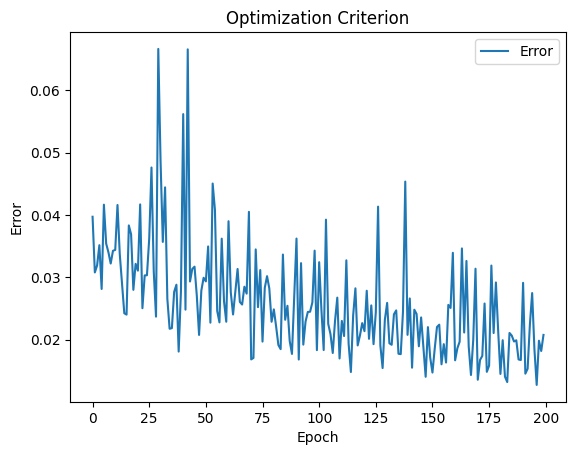

In [29]:
# plot error
plt.plot(total_loss, label='Error')
plt.title('Optimization Criterion')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.show()

Text(0.5, 1.0, 'fixed')

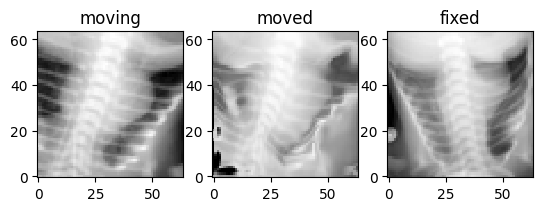

In [30]:
# Evaluation
model.eval()


val_generator = vxm_data_generator(val)
in_sample, out_sample = next(val_generator)

# Convert inputs and true outputs to tensors
inputs = [torch.from_numpy(d).to(device).float().permute(0, 3, 1, 2) for d in in_sample]
y_true = [torch.from_numpy(d).to(device).float().permute(0, 3, 1, 2) for d in out_sample]

# Forward pass through the model to generate predictions
with torch.no_grad():  # Disable gradients for evaluation
    y_pred = model(*inputs)

# plot the images
plt.subplot(1, 3, 1)
plt.imshow(in_sample[0][0], cmap=plt.get_cmap('gray'), aspect='equal',
           origin='lower', interpolation='nearest')
plt.title('moving')

plt.subplot(1, 3, 2)
plt.imshow(y_pred[0].squeeze().cpu().detach().numpy(), cmap=plt.get_cmap('gray'), aspect='equal',
           origin='lower', interpolation='nearest')
plt.title('moved')

plt.subplot(1, 3, 3)
plt.imshow(y_true[0].squeeze().cpu().detach().numpy(), cmap=plt.get_cmap('gray'), aspect='equal',
           origin='lower', interpolation='nearest')
plt.title('fixed')